#Sentiment Analyzer

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
imdb = pd.read_csv("/content/drive/My Drive/FAKT_ML/IMDB Dataset.csv")

In [ ]:
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
imdb.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

###Adatelőkészítés

In [ ]:
corpus = []
for text in imdb['review']:
  words = [word.lower() for word in word_tokenize(text)]
  corpus.append(words)

####Függő és független változók definiálása

In [ ]:
x = imdb.review
y = imdb.sentiment

In [ ]:
print(x.shape, y.shape)

In [ ]:
tokenizer = Tokenizer(len(corpus))
tokenizer.fit_on_texts(x)

x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=128, truncating='post', padding='post')

In [ ]:
x[0], len(x[0])

(array([   27,     4,     1,    79,  2102,    45,  1072,    12,   100,
          147,    39,   307,  3184,   398,   474,    26,  3195,    33,
           23,   203,    14,    11,     6,   621,    48,   596,    16,
           68,     7,     7,     1,    86,   148,    12,  3241,    68,
           42,  3184,    13,    92,  5398,     2, 15115,   134,     4,
          570,    60,   268,     8,   203,    36,     1,   661,   139,
         1740,    68,    11,     6,    21,     3,   119,    15,     1,
         7888,  2333,    38, 11469,    11,   119,  2595,    54,  5911,
           16,  5510,     5,  1479,   376,    38,   570,    92,     6,
         3804,     8,     1,   360,   356,     4,     1,   661,     7,
            7,     9,     6,   433,  3184,    14,    12,     6,     1,
        11648,   358,     5,     1, 15701,  6813,  2538,  1064,     9,
         2711,  1421,    20, 23546,   538,    32,  4636,  2468,     4,
            1,  1208,   117,    29,     1,  7017,    25,  2970, 11964,
      

In [ ]:
labelencoder = LabelEncoder()

y = labelencoder.fit_transform(y)

###Modell architektúrájának létrehozása

In [ ]:
sentiment_analyzer=Sequential()

sentiment_analyzer.add(Embedding(input_dim=len(corpus), output_dim=100, input_length=128, trainable=True))
sentiment_analyzer.add(LSTM(100, dropout=0.1, return_sequences=True))
sentiment_analyzer.add(LSTM(100, dropout=0.1, return_sequences=True))
sentiment_analyzer.add(LSTM(64, dropout=0.1))
sentiment_analyzer.add(Dense(1, activation='sigmoid'))

sentiment_analyzer.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
sentiment_analyzer.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 128, 100)          5000000   
                                                                 
 lstm_21 (LSTM)              (None, 128, 100)          80400     
                                                                 
 lstm_22 (LSTM)              (None, 128, 100)          80400     
                                                                 
 lstm_23 (LSTM)              (None, 64)                42240     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,203,105
Trainable params: 5,203,105
Non-trainable params: 0
_________________________________________________________________


####Early stopping beállítása

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stopping_callback = EarlyStopping(patience=5, restore_best_weights=True)

###Modell tanítása

In [ ]:
history=sentiment_analyzer.fit(x, y, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/100
625/625 [==============================] - 88s 132ms/step - loss: 0.6282 - accuracy: 0.6403 - val_loss: 0.4835 - val_accuracy: 0.7752
Epoch 2/100
625/625 [==============================] - 81s 129ms/step - loss: 0.5825 - accuracy: 0.7012 - val_loss: 0.6270 - val_accuracy: 0.6571
Epoch 3/100
625/625 [==============================] - 81s 130ms/step - loss: 0.4650 - accuracy: 0.7883 - val_loss: 0.4249 - val_accuracy: 0.8209
Epoch 4/100
625/625 [==============================] - 81s 130ms/step - loss: 0.2815 - accuracy: 0.8903 - val_loss: 0.3436 - val_accuracy: 0.8588
Epoch 5/100
625/625 [==============================] - 82s 131ms/step - loss: 0.1867 - accuracy: 0.9345 - val_loss: 0.4030 - val_accuracy: 0.8575
Epoch 6/100
625/625 [==============================] - 81s 129ms/step - loss: 0.1213 - accuracy: 0.9611 - val_loss: 0.4610 - val_accuracy: 0.8470
Epoch 7/100
625/625 [==============================] - 81s 129ms/step - loss: 0.0806 - accuracy: 0.9764 - val_loss: 0.4953 -

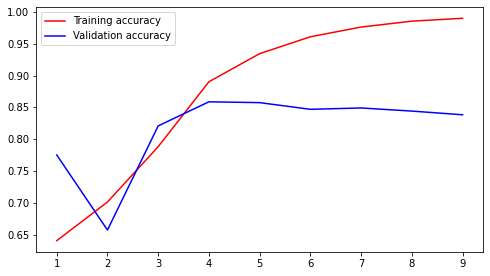

In [ ]:
plt.figure(figsize=(8,4.5))
epochs=range(1, len(history.history['accuracy'])+1)
plt.plot(epochs, history.history['accuracy'], 'b', label='Training accuracy', color='red')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.legend()
plt.show()

###Headline-ok beolvasása és előkészítése

In [ ]:
ukr = pd.read_excel("/content/drive/My Drive/FAKT_ML/sentiment.xlsx")
rus = pd.read_excel("/content/drive/My Drive/FAKT_ML/sentiment_rus.xlsx")

In [ ]:
ukr.headline = ukr.headline.str.lower()
ukr.headline = ukr.headline.str.replace('\.', '')
ukr.headline = ukr.headline.str.replace('\:', '')
ukr.headline = ukr.headline.str.replace("\'", '')
ukr.headline = ukr.headline.str.replace('\"', '')
ukr.headline = ukr.headline.str.replace('\,', '')
ukr.headline = ukr.headline.str.replace('\;', '')
ukr.headline = ukr.headline.str.replace('\-', ' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
rus.headline = rus.headline.str.lower()
rus.headline = rus.headline.str.replace('\.', '')
rus.headline = rus.headline.str.replace('\:', '')
rus.headline = rus.headline.str.replace("\'", '')
rus.headline = rus.headline.str.replace('\"', '')
rus.headline = rus.headline.str.replace('\,', '')
rus.headline = rus.headline.str.replace('\;', '')
rus.headline = rus.headline.str.replace('\-', ' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


###Időszakokra bontjuk a híreket

In [ ]:
ukr_10_13 = ukr.headline[ukr.year<=2013]

In [ ]:
ukr_10_13.head()

0    france joins neighbors in sell off of swine fl...
1    internet pirates find bulletproof havens for i...
2    chernobyl nuclear accident figures for deaths ...
3    orange sunset as ukraine poll heralds turn to ...
4    ukraine welcomes western support but russia is...
Name: headline, dtype: object

In [ ]:
ukr_14_15 = ukr.headline[(ukr.year>2013) & (ukr.year<=2015)]
ukr_16_20 = ukr.headline[(ukr.year>2015) & (ukr.year<=2020)]
ukr_21_22 = ukr.headline[ukr.year>2020]

rus_10_13 = rus.headline[rus.year<=2013]
rus_14_15 = rus.headline[(rus.year>2013) & (rus.year<=2015)]
rus_16_20 = rus.headline[(rus.year>2015) & (rus.year<=2020)]
rus_21_22 = rus.headline[rus.year>2020]

In [ ]:
ukr.shape, rus.shape

((21103, 5), (35869, 5))

In [ ]:
print(ukr_10_13.shape[0] + ukr_14_15.shape[0]+ukr_16_20.shape[0]+ukr_21_22.shape[0])
print(rus_10_13.shape[0] + rus_14_15.shape[0]+rus_16_20.shape[0]+rus_21_22.shape[0])

21103
35869


In [ ]:
ukr_10_13 = tokenizer.texts_to_sequences(ukr_10_13)
ukr_14_15 = tokenizer.texts_to_sequences(ukr_14_15)
ukr_16_20 = tokenizer.texts_to_sequences(ukr_16_20)
ukr_21_22 = tokenizer.texts_to_sequences(ukr_21_22)

ukr_10_13 = pad_sequences(ukr_10_13, maxlen=128, truncating='post', padding='post')
ukr_14_15 = pad_sequences(ukr_14_15, maxlen=128, truncating='post', padding='post')
ukr_16_20 = pad_sequences(ukr_16_20, maxlen=128, truncating='post', padding='post')
ukr_21_22 = pad_sequences(ukr_21_22, maxlen=128, truncating='post', padding='post')

In [ ]:
rus_10_13 = tokenizer.texts_to_sequences(rus_10_13)
rus_14_15 = tokenizer.texts_to_sequences(rus_14_15)
rus_16_20 = tokenizer.texts_to_sequences(rus_16_20)
rus_21_22 = tokenizer.texts_to_sequences(rus_21_22)

rus_10_13 = pad_sequences(rus_10_13, maxlen=128, truncating='post', padding='post')
rus_14_15 = pad_sequences(rus_14_15, maxlen=128, truncating='post', padding='post')
rus_16_20 = pad_sequences(rus_16_20, maxlen=128, truncating='post', padding='post')
rus_21_22 = pad_sequences(rus_21_22, maxlen=128, truncating='post', padding='post')

In [ ]:
#ukr_new = tokenizer.texts_to_sequences(ukr.headline)
#ukr_new = pad_sequences(ukr_new, maxlen=40, truncating='post', padding='post')

In [ ]:
ukr_10_13[0]

array([ 2082,  5177,  5048,     8,  2133,   122,     4, 20846, 15032,
       29678,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [ ]:
len(ukr_10_13)

1469

###Modell futtatása a különböző adatbázisokon

In [ ]:
u_1 = sentiment_analyzer.predict(ukr_10_13)
u_2 = sentiment_analyzer.predict(ukr_14_15)
u_3 = sentiment_analyzer.predict(ukr_16_20)
u_4 = sentiment_analyzer.predict(ukr_21_22)

r_1 = sentiment_analyzer.predict(rus_10_13)
r_2 = sentiment_analyzer.predict(rus_14_15)
r_3 = sentiment_analyzer.predict(rus_16_20)
r_4 = sentiment_analyzer.predict(rus_21_22)

##A különböző hangulatú szalagcímek száma
###Eredmények 0,4-es és 0,6-os cutoff értékekkel


In [ ]:
print("Ukrajna 2010-2013 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(u_1 >= 0.6)),
                                                                        int(sum((u_1 < 0.6)&(u_1>0.4))), int(sum(u_1 <= 0.4))))

Ukrajna 2010-2013 pozitív: 1096, semleges: 206, negatív: 167


In [ ]:
print("Ukrajna 2014-2015 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(u_2 >= 0.6)),
                                                                        int(sum((u_2 < 0.6)&(u_2>0.4))), int(sum(u_2 <= 0.4))))

Ukrajna 2014-2015 pozitív: 4800, semleges: 1005, negatív: 1018


In [ ]:
print("Ukrajna 2016-2020 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(u_3 >= 0.6)),
                                                                        int(sum((u_3 < 0.6)&(u_3>0.4))), int(sum(u_3 <= 0.4))))

Ukrajna 2016-2020 pozitív: 3027, semleges: 739, negatív: 735


In [ ]:
print("Ukrajna 2021-2022 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(u_4 >= 0.6)),
                                                                        int(sum((u_4 < 0.6)&(u_4>0.4))), int(sum(u_4 <= 0.4))))

Ukrajna 2021-2022 pozitív: 5230, semleges: 1534, negatív: 1546


In [ ]:
print("Oroszország 2010-2013 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(r_1 >= 0.6)),
                                                                        int(sum((r_1 < 0.6)&(r_1>0.4))), int(sum(r_1 <= 0.4))))

Oroszország 2010-2013 pozitív: 685, semleges: 170, negatív: 106


In [ ]:
print("Oroszország 2014-2015 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(r_2 >= 0.6)),
                                                                        int(sum((r_2 < 0.6)&(r_2>0.4))), int(sum(r_2 <= 0.4))))

Oroszország 2014-2015 pozitív: 2782, semleges: 651, negatív: 713


In [ ]:
print("Oroszország 2016-2020 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(r_3 >= 0.6)),
                                                                        int(sum((r_3 < 0.6)&(r_3>0.4))), int(sum(r_3 <= 0.4))))

Oroszország 2016-2020 pozitív: 2731, semleges: 706, negatív: 780


In [ ]:
print("Oroszország 2021-2022 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(r_4 >= 0.6)),
                                                                        int(sum((r_4 < 0.6)&(r_4>0.4))), int(sum(r_4 <= 0.4))))

Oroszország 2021-2022 pozitív: 14971, semleges: 6280, negatív: 5294


######Eredmények 0,5-ös és 0,8-as cutoff értékekkel



In [ ]:
print("Ukrajna 2010-2013 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(u_1 >= 0.8)),
                                                                        int(sum((u_1 < 0.8)&(u_1>0.5))), int(sum(u_1 <= 0.5))))

Ukrajna 2010-2013 pozitív: 512, semleges: 715, negatív: 242


In [ ]:
print("Ukrajna 2014-2015 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(u_2 >= 0.8)),
                                                                        int(sum((u_2 < 0.8)&(u_2>0.5))), int(sum(u_2 <= 0.5))))

Ukrajna 2014-2015 pozitív: 2003, semleges: 3433, negatív: 1387


In [ ]:
print("Ukrajna 2016-2020 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(u_3 >= 0.8)),
                                                                        int(sum((u_3 < 0.8)&(u_3>0.5))), int(sum(u_3 <= 0.5))))

Ukrajna 2016-2020 pozitív: 1253, semleges: 2262, negatív: 986


In [ ]:
print("Ukrajna 2021-2022 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(u_4 >= 0.8)),
                                                                        int(sum((u_4 < 0.8)&(u_4>0.5))), int(sum(u_4 <= 0.5))))

Ukrajna 2021-2022 pozitív: 2179, semleges: 4078, negatív: 2053


In [ ]:
print("Oroszország 2010-2013 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(r_1 >= 0.8)),
                                                                        int(sum((r_1 < 0.8)&(r_1>0.5))), int(sum(r_1 <= 0.5))))

Oroszország 2010-2013 pozitív: 360, semleges: 439, negatív: 162


In [ ]:
print("Oroszország 2014-2015 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(r_2 >= 0.8)),
                                                                        int(sum((r_2 < 0.8)&(r_2>0.5))), int(sum(r_2 <= 0.5))))

Oroszország 2014-2015 pozitív: 1193, semleges: 2024, negatív: 929


In [ ]:
print("Oroszország 2016-2020 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(r_3 >= 0.8)),
                                                                        int(sum((r_3 < 0.8)&(r_3>0.5))), int(sum(r_3 <= 0.5))))

Oroszország 2016-2020 pozitív: 1238, semleges: 1951, negatív: 1028


In [ ]:
print("Oroszország 2021-2022 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(r_4 >= 0.8)),
                                                                        int(sum((r_4 < 0.8)&(r_4>0.5))), int(sum(r_4 <= 0.5))))

Oroszország 2021-2022 pozitív: 6227, semleges: 13679, negatív: 6639


###Eredmények 0,5-ös és 0,7-es cutoff értékekkel

In [ ]:
print("Ukrajna 2010-2013 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(u_1 >= 0.7)),
                                                                        int(sum((u_1 < 0.7)&(u_1>0.5))), int(sum(u_1 <= 0.5))))

Ukrajna 2010-2013 pozitív: 876, semleges: 351, negatív: 242


In [ ]:
print("Ukrajna 2014-2015 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(u_2 >= 0.7)),
                                                                        int(sum((u_2 < 0.7)&(u_2>0.5))), int(sum(u_2 <= 0.5))))

Ukrajna 2014-2015 pozitív: 3658, semleges: 1778, negatív: 1387


In [ ]:
print("Ukrajna 2016-2020 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(u_3 >= 0.7)),
                                                                        int(sum((u_3 < 0.7)&(u_3>0.5))), int(sum(u_3 <= 0.5))))

Ukrajna 2016-2020 pozitív: 2356, semleges: 1159, negatív: 986


In [ ]:
print("Ukrajna 2021-2022 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(u_4 >= 0.7)),
                                                                        int(sum((u_4 < 0.7)&(u_4>0.5))), int(sum(u_4 <= 0.5))))

Ukrajna 2021-2022 pozitív: 4139, semleges: 2118, negatív: 2053


In [ ]:
print("Oroszország 2010-2013 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(r_1 >= 0.7)),
                                                                        int(sum((r_1 < 0.7)&(r_1>0.5))), int(sum(r_1 <= 0.5))))

Oroszország 2010-2013 pozitív: 546, semleges: 253, negatív: 162


In [ ]:
print("Oroszország 2014-2015 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(r_2 >= 0.7)),
                                                                        int(sum((r_2 < 0.7)&(r_2>0.5))), int(sum(r_2 <= 0.5))))

Oroszország 2014-2015 pozitív: 2063, semleges: 1154, negatív: 929


In [ ]:
print("Oroszország 2016-2020 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(r_3 >= 0.7)),
                                                                        int(sum((r_3 < 0.7)&(r_3>0.5))), int(sum(r_3 <= 0.5))))

Oroszország 2016-2020 pozitív: 2103, semleges: 1086, negatív: 1028


In [ ]:
print("Oroszország 2021-2022 pozitív: {}, semleges: {}, negatív: {}".format(int(sum(r_4 >= 0.7)),
                                                                        int(sum((r_4 < 0.7)&(r_4>0.5))), int(sum(r_4 <= 0.5))))

Oroszország 2021-2022 pozitív: 10692, semleges: 9214, negatív: 6639
